# Transfer entropy exploration

In [1]:
import numpy as np
import xarray as xr

from tqdm.notebook import tqdm

from frites.simulations import sim_single_suj_ephy
from frites.conn import conn_te
from cfutils import set_mpl_style
from cfutils.config import PALETTE_RGB_N

from matplotlib import pyplot as plt

set_mpl_style()

np.random.seed(0)

### Testing Cholesky problem

In [2]:
n = 500
x = np.random.default_rng().normal(0.0, 1.0, n)
y = x.copy()
y += 0.1 * np.random.rand(n)
xy = np.array([x, y])
cov = np.einsum("ij, kj->ik", xy, xy) / (n - 1.0)
print(cov)
print("positive eigenvalues:", np.all(np.linalg.eigvals(cov) > 0))


[[1.03526853 1.03259075]
 [1.03259075 1.03323523]]
positive eigenvalues: True


In [137]:
np.linalg.cholesky(cov)

array([[0.97322095, 0.        ],
       [0.97333847, 0.00575464]])

### Testing Transfer Entropy

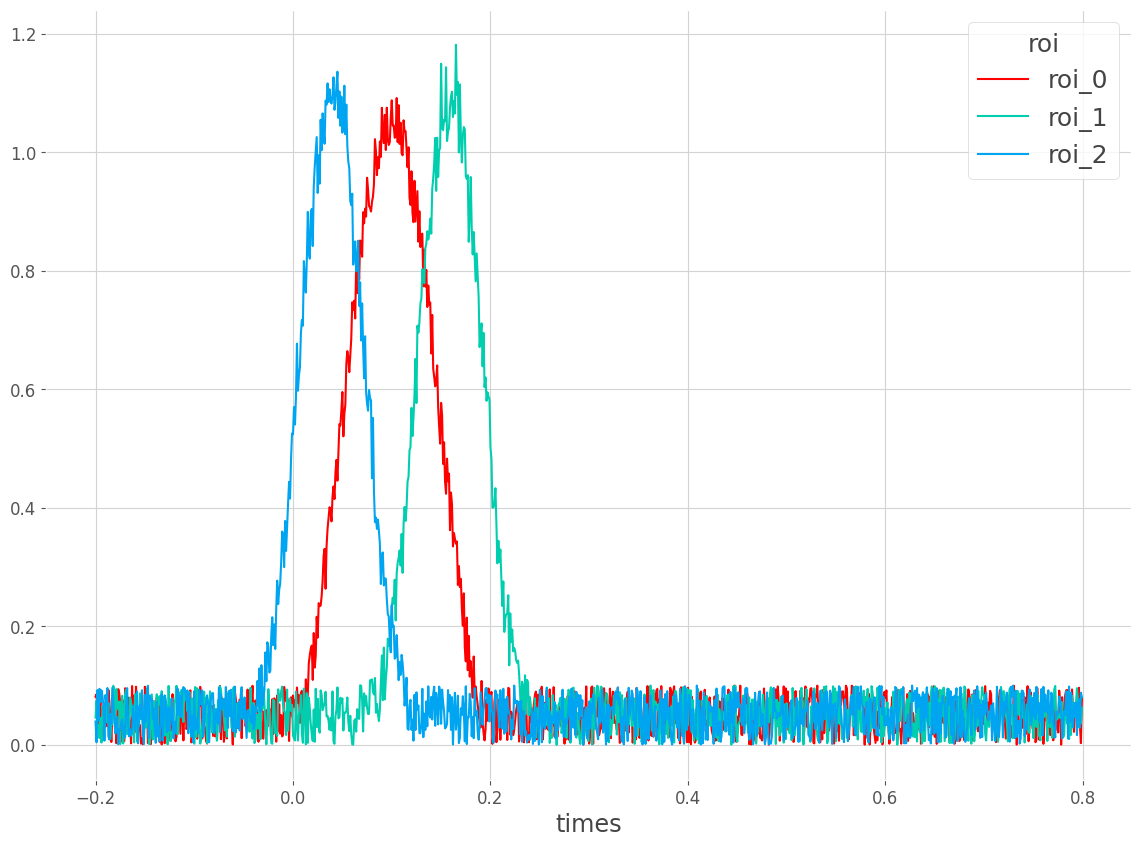

In [30]:
n_trials = 1
n_roi = 3
n_times = 1000
ref = 200
bump_len = 200
fs=1000

trials = np.arange(n_trials)
roi = [f"roi_{k}" for k in range(n_roi)]
times = (np.arange(n_times) - ref) / fs

data = 0.1 * np.random.rand(n_trials, n_roi, n_times)
bump = np.hanning(bump_len).reshape(1, -1)


lags = {1: int(0.06*fs), 2: int(-0.06*fs)}
data[:, 0, ref : ref + bump_len] += bump
for t, lag in lags.items():
    data[:, t, ref + lag : ref + lag + bump_len] += data[:, 0, ref : ref + bump_len] * bump

data = xr.DataArray(data, dims=("trials", "roi", "times"), coords=(trials, roi, times))

data.mean("trials").plot(x="times", hue="roi")
plt.show()
data = np.asarray(data)

In [24]:
# def compute_h2(x, y, n_bins=10, bins_props=False):
#     """Compute h2 coefficient as x->y."""
#     n = len(x)
#     y_var = np.var(y)
#     w = int(n / n_bins)
#     bn_slices = [slice(i * w, i * w + w) for i in range(n_bins)]
#     sort_indices = np.argsort(x)
#     y = np.array([y[sort_indices[s]] for s in bn_slices])
#     y_centroids = np.mean(y, axis=1)[:, np.newaxis]
#     hxy = 1 - np.sum(np.concatenate(np.power(y - y_centroids, 2))) / (y_var*n)

#     if bins_props:
#         # return x/y centroids and bins indices
#         x_centroids = [x[sort_indices[s]].mean() for s in bn_slices]
#         bn_indices=[(sort_indices[s.start],sort_indices[s.stop-1]) 
#                     for s in bn_slices]
#         return hxy, x_centroids, y_centroids, bn_indices

#     return hxy


In [37]:
def compute_h2(x, y, n_bins=10):
    """Compute h2 coefficient as x->y."""
    y_var = np.var(y)
    w = int(n / n_bins)
    bn_slices = [slice(i * w, i * w + w) for i in range(n_bins)]
    sort_indices = np.argsort(x)
    y = np.array([y[sort_indices[s]] for s in bn_slices])
    y_centroids = np.mean(y, axis=1)[:, np.newaxis]
    hxy = 1 - np.sum(np.concatenate(np.power(y - y_centroids, 2))) / (y_var*n)

    return hxy
    

In [55]:
def compute_h2_delays(x, y, max_delay, n_bins=10):
    """Compute h2 coefficient as x->y."""
    delays = np.arange(-max_delay, 1, 1, dtype=int)
    n=len(x)
    hxy_delays=list()
    hyx_delays=list()
    for d in delays:
        hxy_delays.append(compute_h2(x[d:-1], y[0:n+d],n_bins))
        hyx_delays.append(compute_h2(y[d:-1], x[0:n+d],n_bins))

    return np.max(hxy_delays),np.max(hyx_delays)

In [57]:
x = data[0, 0, :]
y = data[0, 1, :]
n = len(x)

w = 200
lag = 60
n_bins = 10
max_delay= 0.1*fs # 100 ms
w_len=int(0.2*fs) # 200 ms usually 5 sec
w_step=int(0.05*fs) # 50 ms usually 0.5 sec
delays = np.arange(-max_delay, 1, 1)
hxy=list()
hyx=list()
w_times=np.arange(0,n-w_len,w_step)
for t in w_times:
    hxy_max,hyx_max=compute_h2_delays(x[t:t+w_len], y[t:t+w_len], max_delay)
    hxy.append(hxy_max)
    hyx.append(hyx_max)

plt.plot(w_times,hxy, color=PALETTE_RGB_N[0])
plt.plot(w_times,hyx, color=PALETTE_RGB_N[1])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [ ]:
modality = "meeg"
n_roi = 3
n_epochs = 500
n_times = 1000
x, roi, _ = sim_single_suj_ephy(
    n_epochs=n_epochs, n_times=n_times, modality=modality, n_roi=n_roi, random_state=0
)
trials = np.arange(n_epochs)
times = np.linspace(-1, 1, n_times)

# simulate relationship
# source, target
relationships = [
    {0: slice(550, 650), 1: slice(750, 850)},
    {1: slice(600, 650), 2: slice(700, 750)},
]

for r in relationships:
    region = list(r.keys())
    windows = list(r.values())
    w_s = np.around((times[windows[0].start], times[windows[0].stop]), 3)
    w_t = np.around((times[windows[1].start], times[windows[1].stop]), 3)
    # target = source
    x[:, region[1], windows[1]] += x[:, region[0], windows[0]]
    print(f"|{roi[region[0]]}:{w_s}|->|{roi[region[1]]}:{w_t}|")

# convert to xr
x = xr.DataArray(x, dims=("trials", "roi", "times"), coords=(trials, roi, times))

fig, axs = plt.subplots(n_roi, 1)

for j, ax in enumerate(axs):
    x.mean("trials")[j].plot(x="times", color=PALETTE_RGB_N[j], ax=ax)
    ax.set_xlim([times.min(), times.max()])

for j, r in enumerate(relationships):
    for k, w in r.items():
        axs[k].axvline(times[w.start], color=PALETTE_RGB_N[-1 - j], linestyle="--")
        axs[k].axvline(times[w.stop], color=PALETTE_RGB_N[-1 - j], linestyle="--")


plt.tight_layout()
plt.show()

In [177]:
min_delay, max_delay, step_delay = 50, 100, 1
te = conn_te(
    x,
    times="times",
    roi="roi",
    n_jobs=-1,
    min_delay=min_delay,
    max_delay=max_delay,
    step_delay=step_delay,
    return_delays=False,
)


Defining links (n_roi=3; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=6, delays=[50:1:100])
100%|██████████| Estimating TE : 6/6 [00:00<00:00, 3005.59it/s]


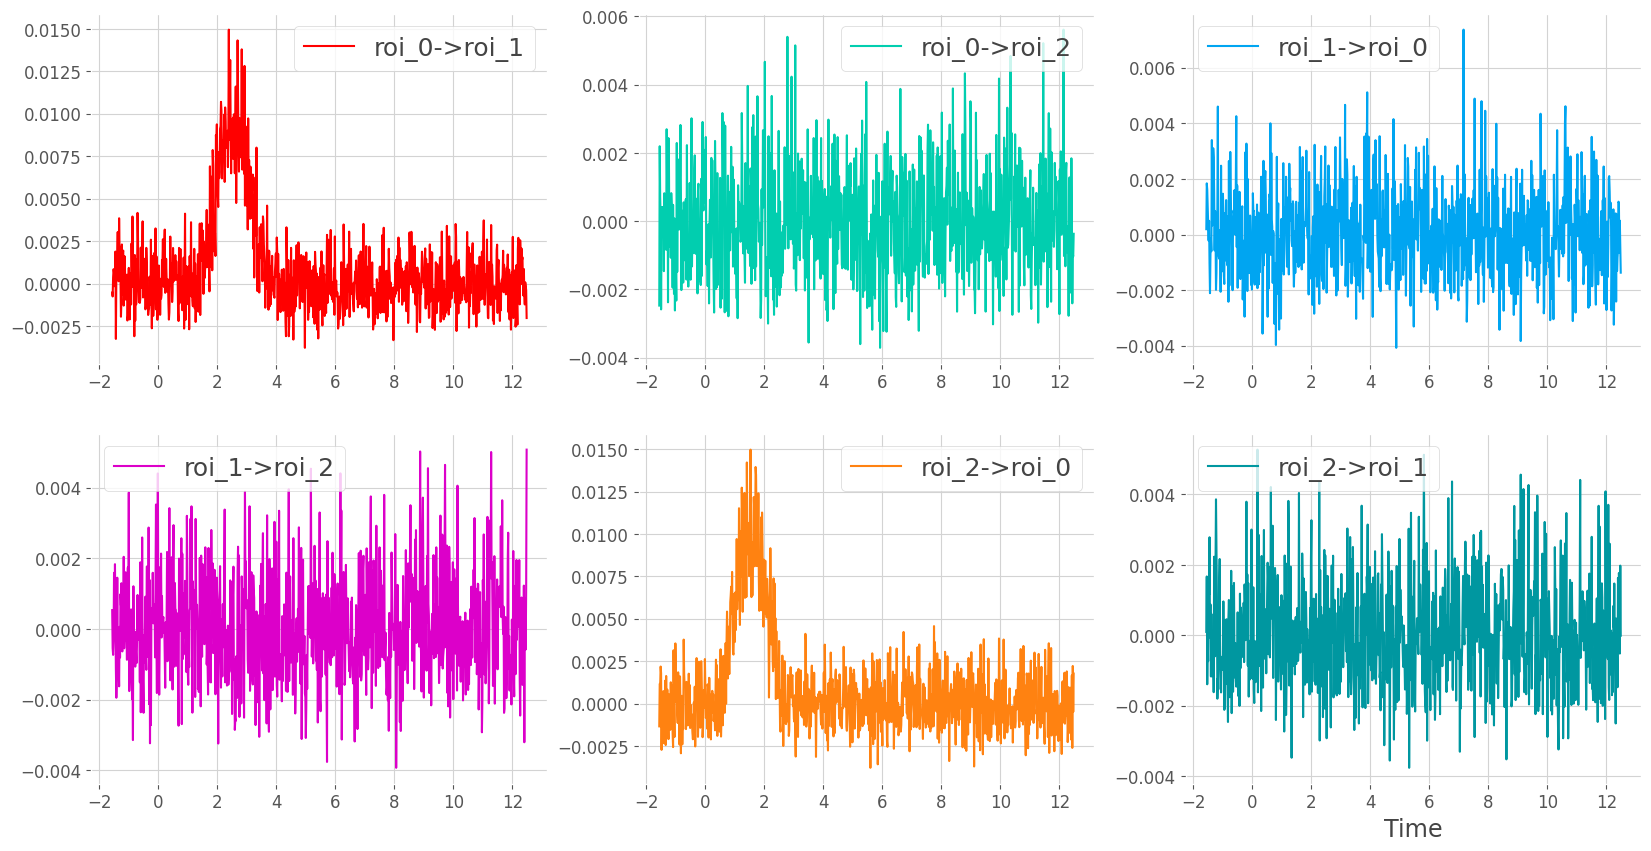

In [178]:
roi_p = te["roi"].data
fig, axes = plt.subplots(2, int(len(roi_p) / 2), figsize=(20, 10))
j = 0
for r, ax in zip(roi_p, axes.flat):
    ax.plot(te.times.data, te.sel(roi=r).T, color=PALETTE_RGB_N[j], label=r)
    ax.legend()
    j += 1

plt.xlabel("Time")
plt.show()